In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

Data cleaning

In [2]:
##### Functions used throughout

# Giving repeated words unique labels
def unique_word_labels(data):
    word_count = {}
    last_word = None
    unique_data = []

    for index, row in data.iterrows():
        word = row['word']
        
        # Check if this is a repeated word
        if word == last_word:
            # Use the same label as the previous occurrence if it's in a clump
            unique_word = unique_data[-1]['word']
        else:
            # If it's a new occurrence or a different word
            count = word_count.get(word, 0) + 1
            word_count[word] = count

            if count == 1:
                unique_word = word  # First occurrence remains the same
            else:
                unique_word = f"{word}-{count}"  # Label subsequent occurrences uniquely

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        last_word = word  # Update the last seen word

    
    return pd.DataFrame(unique_data)

def get_word_data(word, words_data, pitch_data, singer_name):
    word_notes = words_data[words_data['word'] == word]
    start_time = word_notes['timestamp'].min()
    end_time = word_notes.iloc[-1]['timestamp'] + word_notes.iloc[-1]['duration']

    # Adjusting the timestamps relative to the word's start
    adjusted_word_notes = word_notes.copy()
    adjusted_word_notes['adjusted_timestamp'] = adjusted_word_notes['timestamp'] - start_time

    # Filtering and adjusting pitch data
    filtered_pitch_data = pitch_data[(pitch_data['frequency'] >= 100) & (pitch_data['timestamp'] >= start_time) & (pitch_data['timestamp'] <= end_time)].copy()
    filtered_pitch_data['adjusted_timestamp'] = filtered_pitch_data['timestamp'] - start_time

    return {
        'word': word,
        'note_data': adjusted_word_notes,
        'pitch_data': filtered_pitch_data,
        'singer': singer_name
    }

def dtw_distance(series1, series2):
    len_s1, len_s2 = len(series1), len(series2)
    DTW = [[float('inf') for _ in range(len_s2)] for _ in range(len_s1)]
    DTW[0][0] = 0

    for i in range(1, len_s1):
        for j in range(1, len_s2):
            cost = abs(series1[i] - series2[j])
            DTW[i][j] = cost + min(DTW[i-1][j],    # Insertion
                                   DTW[i][j-1],    # Deletion
                                   DTW[i-1][j-1])  # Match

    return DTW[len_s1 - 1][len_s2 - 1]

def chaos_score(pitch_data1, pitch_data2):
    frequency1 = pitch_data1['frequency'].values
    frequency2 = pitch_data2['frequency'].values

    distance = dtw_distance(frequency1, frequency2)
    return distance

In [3]:
# Assemble performance data
def performance(singer):
    return {
        'words_data': unique_word_labels(pd.DataFrame(pd.read_csv('words/' + singer + '.csv'))),
        'pitch_data': pd.DataFrame(pd.read_csv('pitch/' + singer + '.csv'))
    }

singers = ['jazmine', 'carrie', 'harry', 'demi', 'michelle']

performances = {singer: performance(singer) for singer in singers}

In [4]:
# Get shapes for all words in all performances
shapes = []
for singer, data in performances.items():
    unique_words = set(data['words_data']['word'])
    shapes.extend([get_word_data(word, data['words_data'], data['pitch_data'], singer) for word in unique_words])
    
# Create distance matrix
distance_matrix = []
filename = "distance_matrix_5.npy"

# Check if the file exists
if os.path.exists(filename):
    # Load the distance matrix
    distance_matrix = np.load(filename)
    print("Loaded distance matrix from file.")
    print(distance_matrix)
else:
    num_shapes = len(shapes)
    print(num_shapes)
    distance_matrix = []

    for i, shape1 in enumerate(shapes):
        row = []
        for j, shape2 in enumerate(shapes):
            if i == j:
                # Skip comparing the shape with itself and set distance to 0
                distance = 0
            else:
                distance = chaos_score(shape1['pitch_data'], shape2['pitch_data'])
            row.append(distance)
        distance_matrix.append(row)

        # Print progress
        print(f"Processed shape {i+1} of {num_shapes}")

    # Convert to numpy array for easy saving
    distance_matrix = np.array(distance_matrix)

    # Save the distance matrix to a file
    np.save(filename, distance_matrix)
    print("Distance matrix computation complete and saved to file.")

Loaded distance matrix from file.
[[    0.     7791.806  6317.275 ... 26655.261   568.426 32587.731]
 [ 7791.806     0.     3106.664 ... 39860.354 10856.516 45941.863]
 [ 6317.275  3106.664     0.    ... 46081.406 11378.312 73209.44 ]
 ...
 [26655.261 39860.354 46081.406 ...     0.    24178.938 21977.449]
 [  568.426 10856.516 11378.312 ... 24178.938     0.    31508.547]
 [32587.731 45941.863 73209.44  ... 21977.449 31508.547     0.   ]]


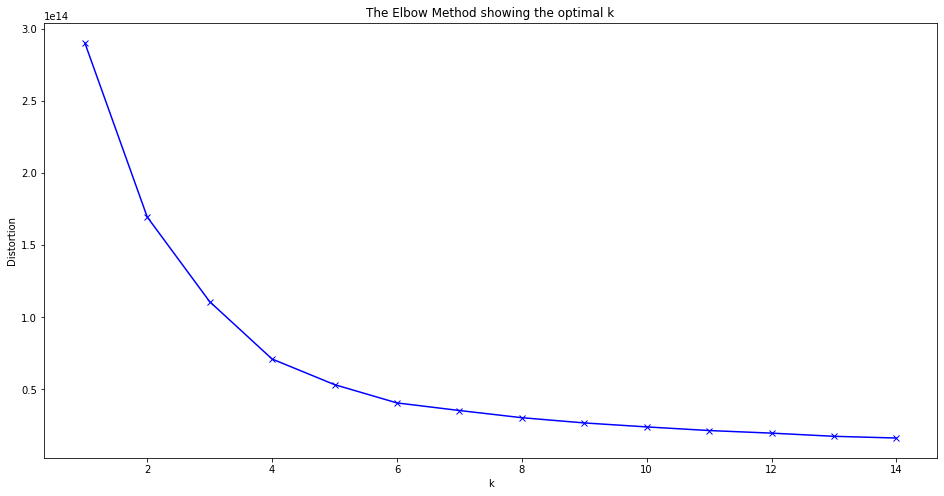

In [5]:
# Elbow method
distortions = []
K = range(1, 15)  # Range of k values to try.

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10)
    kmeanModel.fit(distance_matrix)
    distortions.append(kmeanModel.inertia_)

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
# K-means
k = 10
kmeans = KMeans(n_clusters=k, n_init=10)
clusters = kmeans.fit_predict(distance_matrix)

# Show clusters
clustered_words = pd.DataFrame({
    'word': unique_words,
    'cluster': clusters
})

# Grouping clusters
grouped = clustered_words.groupby('cluster')

for cluster, group in grouped:
    print(f"Cluster {cluster}:")
    words_in_cluster = group['word'].tolist()
    print(", ".join(words_in_cluster))
    print()  # Adding a blank line for better readability

ValueError: All arrays must be of the same length